# Johdanto datatieteeseen 2021

## Harjoitustyö

### Asunnon myyntihinnan ennustaminen

Analyysin tavoitteena on ennustaa myyntihinta asunnolle Tampereen alueella. Ennustettu hinta perustuu etuovi.com -sivustolla Tampereen seudulla myynnissä olevien asuntojen hintoihin. Analysiin tuloksena syntyi streamlit-pohjainen työkalu, jolla asunnon myyntihinnan ennustaminen onnistuu. 

### Datan kerääminen

Data on kerätty etuovi.com -sivustolta. 

In [1]:
# Tehdään importit.
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import re
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
import seaborn as sns

In [2]:
my_url = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1640145379&sivu='
page = requests.get(my_url)
soup = BeautifulSoup(page.text, 'html.parser')

pages = []
buttons = soup.findAll('button', {'class': 'Pagination__button__3H2wX'})
for button in buttons:
    pages.append(button.text)
    
last_page = int(pages[-1])

all_listings = []
for sivu in range(1, last_page):
    
    req = requests.get(my_url + str(sivu))
    page_soup = BeautifulSoup(req.text, 'html.parser')
    containers = page_soup.findAll('div', {'class': 'ListPage__cardContainer__39dKQ'})
    
    for container in containers:
        size_list = container.find('div', {'class': 'flexboxgrid__col-xs__26GXk flexboxgrid__col-md-4__2DYW-'}).text
        size_number = re.findall("\d+\,*\d+", size_list)
        size = ''.join(size_number) 

        price_line = container.find('div', {'class': 'flexboxgrid__col-xs-4__p2Lev flexboxgrid__col-md-4__2DYW-'}).text
        price_number_list = re.findall("\d+\d+", price_line)
        price = ''.join(price_number_list[:2]) 
        
        address_city = container.h4.text

        address_list = address_city.split(', ')[0:1]
        address = ' '.join(address_list) 

        city_part = address_city.split(', ')[-2]  

        city = address_city.split(', ')[-1] 

        type_org = container.h5.text
        type = type_org.replace("|", "").replace(",", "").replace(".", "") 

        year_list = container.find("div", {"class": "flexboxgrid__col-xs-3__3Kf8r flexboxgrid__col-md-4__2DYW-"}).text
        year_number = re.findall("\d+", year_list)
        year = ' '.join(year_number)
        
        single_listing = [size, price, address, city_part, city, type, year]
        all_listings.append(single_listing)

In [3]:
df = pd.DataFrame(all_listings, columns=['Neliöt', 'Hinta', 'Osoite', 'Kaupunginosa', 'Kaupunki', 'Kuvaus', 'Rakennusvuosi'])
df.to_csv('listings.csv', index=False)

### Datan jalostaminen

In [4]:
df.head(5)

,Neliöt,Hinta,Osoite,Kaupunginosa,Kaupunki,Kuvaus,Rakennusvuosi
0,"75,3",240000,Vellamonkatu 8,Tammela,Tampere,Kerrostalo 3h k kph lasitettu parvke,1971
1,"144,5",424000,Simolankatu 18 C,Kaarila,Tampere,Rivitalo 4h k s th,1991
2,58,16712,OLLINOJANKATU 11,Lintulampi,Tampere,Kerrostalo 2H + K + S,1998
3,75,228000,Vesakonkatu 1 A,Hallila,Tampere,Rivitalo 3h k,1992
4,90,289000,Heinurinkuja 3 A 8,Lintuhytti,Tampere,Rivitalo 4h + k + kph + khh + vh + s + ak,2017


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Neliöt         1950 non-null   object
 1   Hinta          1950 non-null   object
 2   Osoite         1950 non-null   object
 3   Kaupunginosa   1950 non-null   object
 4   Kaupunki       1950 non-null   object
 5   Kuvaus         1950 non-null   object
 6   Rakennusvuosi  1950 non-null   object
dtypes: object(7)
memory usage: 106.8+ KB


In [6]:
# Pudotetaan datasetistä pois sarakkeet, joita ei oteta mukaan analyysiin.
df = df.drop(['Osoite', 'Kaupunki'], axis=1)

In [7]:
kaupunginosa_counts = Counter(df.Kaupunginosa)
print(kaupunginosa_counts)

Counter({'Keskusta': 209, 'Ranta-Tampella': 178, 'Vuores': 105, 'Hervantajärvi': 103, 'Hervanta': 102, 'Santalahti': 98, 'Kaleva': 95, 'Tammela': 81, 'Niemenranta': 79, 'Tesoma': 77, 'Koivistonkylä': 76, 'Härmälänranta': 64, 'Hatanpää': 62, 'Takahuhti': 59, 'Pyynikki': 56, 'Annala': 45, 'Haukiluoma': 24, 'Kaukajärvi': 23, 'Lentävänniemi': 18, 'Rahola': 15, 'Olkahinen': 14, 'Armonkallio': 13, 'Pispala': 13, 'Amuri': 13, 'Härmälä': 12, 'Peltolammi': 12, 'Janka': 12, 'Multisilta': 12, 'Pohtola': 10, 'Kalkku': 10, 'Haapalinna': 10, 'Ikuri': 10, 'Linnainmaa': 10, 'Vehmainen': 9, 'Atala': 8, 'Nekala': 8, 'Leinola': 8, 'Ryydynpohja': 7, 'Ruotula': 7, 'Hallila': 6, 'Tahmela': 6, 'Onkiniemi': 6, 'Lamminpää': 6, 'Lielahti': 6, 'Hyhky': 6, 'Holvasti': 6, 'Lukonmäki': 6, 'Kämmenniemi': 6, 'Tampere': 6, 'Niemi': 5, 'Terälahti': 5, 'Järvensivu': 5, 'Hakametsä': 5, 'Epilä': 5, 'Lintuhytti': 4, 'Viiala': 4, 'Tampella': 4, 'Petsamo': 4, 'Kaarila': 3, 'Palokallio': 3, 'Pappila': 3, 'Rantaperkiö': 3, 'Ir

Kuten ylläolevasta voidaan huomata, niin kaupunginosien kirjoitusasut saattavat hieman poiketa toisistaan, jonka vuoksi osa asuinalueen asunnoista lasketaan mukaan eri ryhmään. Muutetaan kaikki kirjaimet pieniksi ja poistetaan erikoismerkit, jolloin varmistetaan, että saman kaupunginosan asunnot todella lasketaan mukaan oikeaan ryhmään. 

In [8]:
df['Kaupunginosa'] = df['Kaupunginosa'].str.lower()
df['Kaupunginosa'] = df['Kaupunginosa'].str.replace('[^A-Za-zÄäÖö\s]+', '')

# Datasetti sisältää myös joitakin virheellisiä kaupunginosien nimiä, joten poistetaan ne.
indexes = df[(df['Kaupunginosa'] == 'tampere') | (df['Kaupunginosa'] == 'annalakaipaisenrinne') | (df['Kaupunginosa'] == 'saarenvainionkatu  e')].index
df = df.drop(indexes)

kaupunginosa_counts = Counter(df.Kaupunginosa)
print(kaupunginosa_counts)

Counter({'keskusta': 211, 'rantatampella': 178, 'vuores': 106, 'hervanta': 103, 'hervantajärvi': 103, 'santalahti': 98, 'kaleva': 95, 'tammela': 81, 'niemenranta': 79, 'tesoma': 78, 'koivistonkylä': 76, 'härmälänranta': 64, 'hatanpää': 62, 'takahuhti': 59, 'pyynikki': 56, 'annala': 45, 'haukiluoma': 24, 'kaukajärvi': 24, 'lentävänniemi': 18, 'rahola': 15, 'olkahinen': 14, 'armonkallio': 13, 'pispala': 13, 'amuri': 13, 'härmälä': 12, 'peltolammi': 12, 'janka': 12, 'multisilta': 12, 'pohtola': 10, 'kalkku': 10, 'haapalinna': 10, 'ikuri': 10, 'linnainmaa': 10, 'vehmainen': 9, 'atala': 8, 'nekala': 8, 'leinola': 8, 'ryydynpohja': 7, 'ruotula': 7, 'hallila': 6, 'tahmela': 6, 'onkiniemi': 6, 'lamminpää': 6, 'lielahti': 6, 'hyhky': 6, 'holvasti': 6, 'lukonmäki': 6, 'kämmenniemi': 6, 'niemi': 5, 'terälahti': 5, 'järvensivu': 5, 'hakametsä': 5, 'epilä': 5, 'lintuhytti': 4, 'viiala': 4, 'tampella': 4, 'petsamo': 4, 'kaarila': 3, 'palokallio': 3, 'rautaharkko': 3, 'pappila': 3, 'rantaperkiö': 3, 

Neliöt-sarake vaatii myös enemmän siivoamista, sillä osa arvoista on luonnottoman suuria. Poistetaan siis rivit, joissa merkkijono on liian pitkä tai arvo liian suuri. Poistetaan lisäksi rivit, joissa asunnon hinta on pienempi kuin 50 000 €, sillä silloin kyseessä on todennäköisesti asumisoikeusasunto. Tehdään myös tyyppimuunnoksia. 

In [9]:
df['Neliöt_pituus'] = df['Neliöt'].str.len()
indexNames = df[ df['Neliöt_pituus'] > 5 ].index
df = df.drop(indexNames)
df = df.drop(['Neliöt_pituus'], axis=1)

df['Neliöt'] = df['Neliöt'].replace('[\,,)]','.',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

indexNames = df[ df['Neliöt'] > 1000 ].index
df = df.drop(indexNames)

# Poistetaan rivit, jotka sisältävät tyhjiä arvoja.
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df = df.dropna()

df['Hinta'] = df['Hinta'].replace('[(]','-', regex=True).astype(int)
indexPrice = df[ df['Hinta'] < 50000 ].index
df = df.drop(indexPrice)

df['Rakennusvuosi'] = df['Rakennusvuosi'].replace('[(]','-', regex=True).astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1737 entries, 0 to 1949
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Neliöt         1737 non-null   float64
 1   Hinta          1737 non-null   int32  
 2   Kaupunginosa   1737 non-null   object 
 3   Kuvaus         1737 non-null   object 
 4   Rakennusvuosi  1737 non-null   int32  
dtypes: float64(1), int32(2), object(2)
memory usage: 67.9+ KB


In [11]:
# Poimitaan kuvaus-sarakkeesta asuntotyypit ja tehdään niistä uusi tyyppi-sarake.
df['Tyyppi'] = df['Kuvaus'].str.split(' ').str[0]
df = df.drop(['Kuvaus'], axis=1)
df.to_csv('df.csv', index=False)
df.head()

,Neliöt,Hinta,Kaupunginosa,Rakennusvuosi,Tyyppi
0,75.3,240000,tammela,1971,Kerrostalo
1,144.5,424000,kaarila,1991,Rivitalo
3,75.0,228000,hallila,1992,Rivitalo
4,90.0,289000,lintuhytti,2017,Rivitalo
5,21.5,119000,niemi,2019,Kerrostalo


In [12]:
# Käsitellään kategoriset muuttujat.
k_dummies = pd.get_dummies(df.Kaupunginosa)
t_dummies = pd.get_dummies(df.Tyyppi)

alldata = pd.concat((df.drop(['Kaupunginosa', \
    'Tyyppi'], axis=1), \
    k_dummies.astype(int), t_dummies.astype(int)), axis=1)
allcols = alldata.columns
alldata.to_csv('ad.csv', index=False)
alldata.head(5)

,Neliöt,Hinta,Rakennusvuosi,alapispala,amuri,annala,armonkallio,atala,epilä,finninmäki,...,villilä,vuohenoja,vuores,Erillistalo,Kerrostalo,Luhtitalo,Omakotitalo,Paritalo,Puutalo-osake,Rivitalo
0,75.3,240000,1971,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,144.5,424000,1991,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,75.0,228000,1992,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,90.0,289000,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,21.5,119000,2019,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Datan kuvaileminen

Jo datan jalostus vaiheessa voitiin huomata, että joillakin asuinalueilla on myynnissä vain hyvin vähän asuntoja. Suurimmalla osalla asuinalueista myytävien asuntojen määrä jää alle kymmeneen.  

<AxesSubplot:>

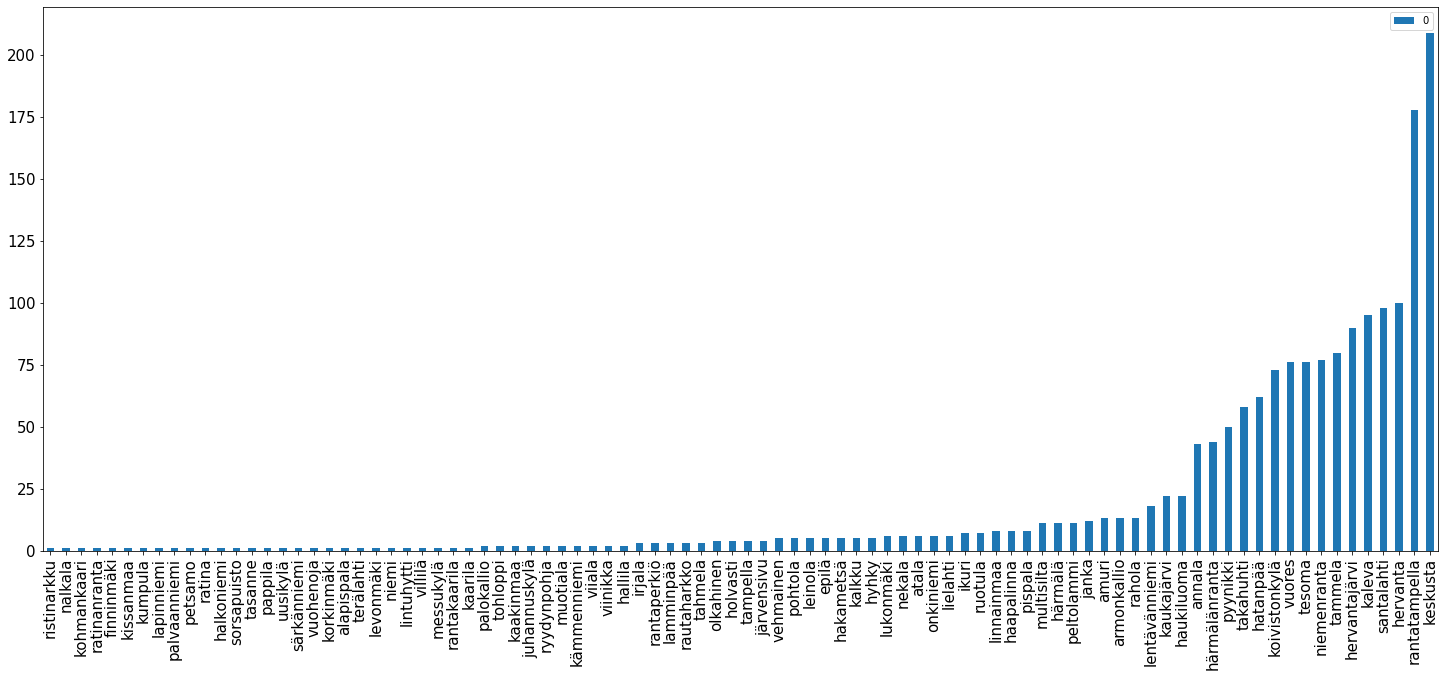

In [13]:
# Asuntojen määrä asuinalueittain.
kaupunginosa_counts = Counter(df.Kaupunginosa)
tdf = pd.DataFrame.from_dict(kaupunginosa_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar', figsize = (25,10), fontsize = 15)

In [14]:
df['Hinta'].describe()

count      1737.000000
mean     238025.560737
std      132252.254601
min       59000.000000
25%      150000.000000
50%      201010.000000
75%      277000.000000
max      990000.000000
Name: Hinta, dtype: float64

<AxesSubplot:title={'center':'Median prices'}, xlabel='Kaupunginosa'>

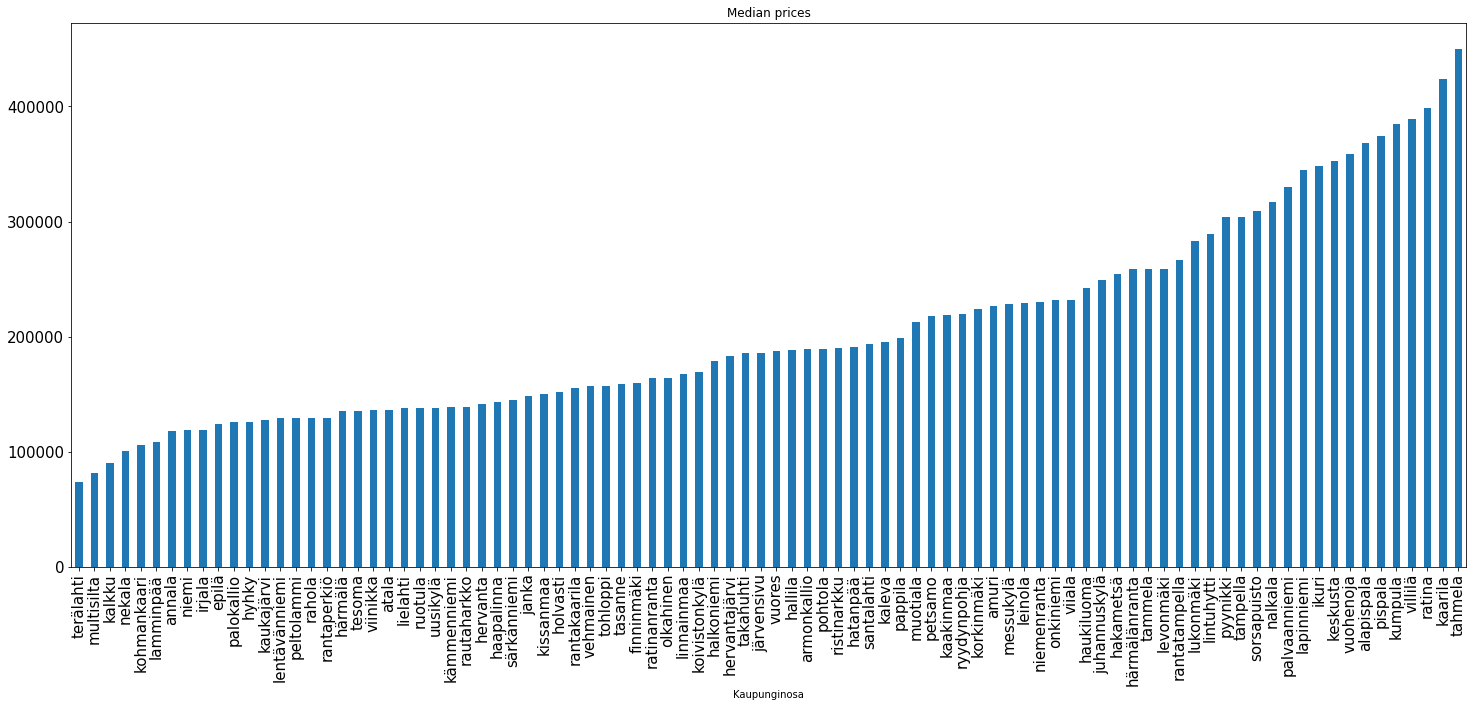

In [15]:
# Asuntojen mediaanihinnat kaupunginosittain.
median_price = df.groupby('Kaupunginosa')['Hinta'].median().sort_values()

plt.title('Median prices')
median_price.plot(kind='bar', figsize = (25,10), fontsize = 15)

<AxesSubplot:title={'center':'Median prices'}, xlabel='Tyyppi'>

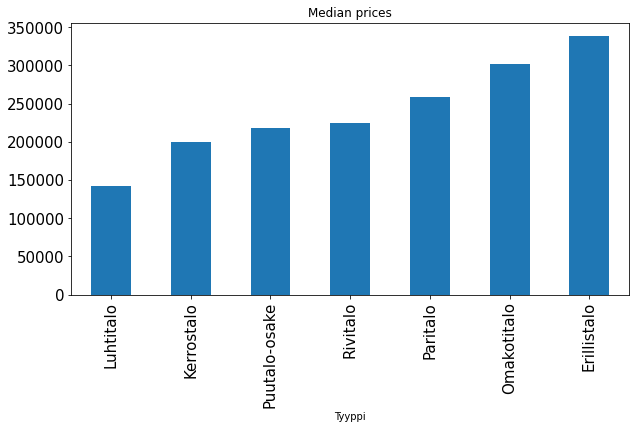

In [16]:
# Mediaanihinnat per asuntotyyppi.
median_price = df.groupby('Tyyppi')['Hinta'].median().sort_values()

plt.title('Median prices')
median_price.plot(kind='bar', figsize = (10,5), fontsize = 15)

Suurin osa myynnissä olevista asunnoista on kerrostaloja. Joitakin asuntotyyppejä on myynnissä vain muutamia.

<AxesSubplot:xlabel='Tyyppi', ylabel='count'>

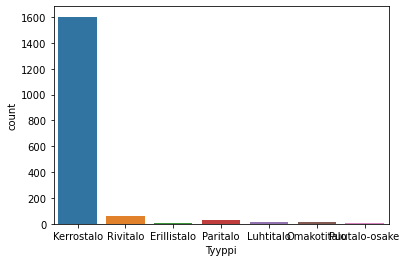

In [17]:
# Asuntojen määrä tyypeittäin.
sns.countplot(x='Tyyppi', data=df)

<AxesSubplot:xlabel='Hinta', ylabel='Neliöt'>

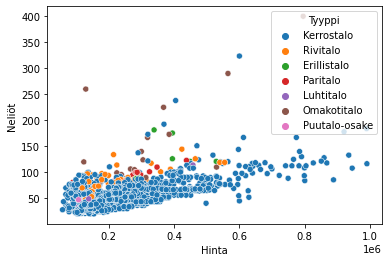

In [18]:
sns.scatterplot(x='Hinta', y ='Neliöt' ,
data = df , hue = 'Tyyppi')

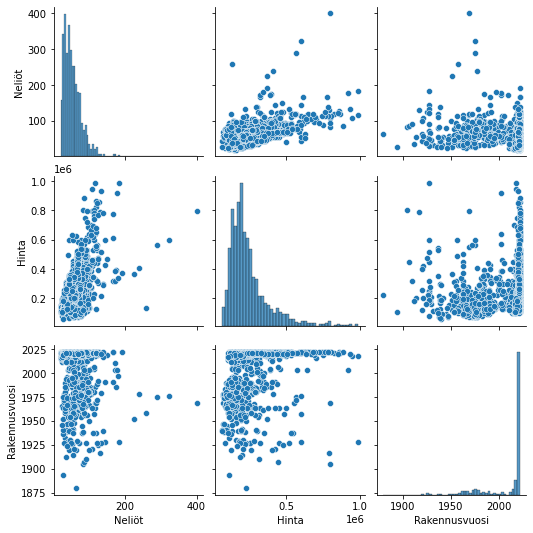

In [19]:
sns.pairplot(df)

<AxesSubplot:>

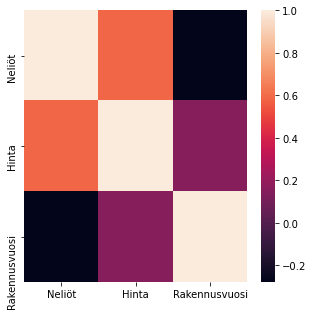

In [20]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr())

Kahden ylläolevan matriisin avulla tutkitaan sarakkeiden keskinäisiä riippuvuuksia. Näiden kuvaajien perusteella ei nouse esiin mitään ilmeisiä ongelmia.

### Koneoppiminen

Text(0, 0.5, 'Median Absolute Error')

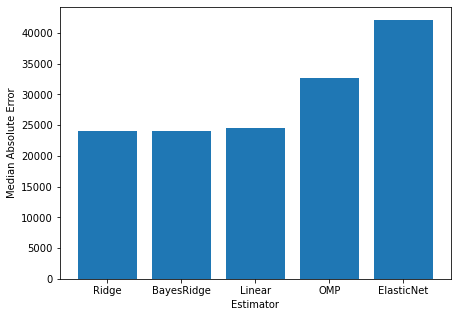

In [21]:
ests = [linear_model.LinearRegression(), linear_model.Ridge(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit()]

ests_labels = np.array(['Linear', 'Ridge', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['Hinta'], axis=1),
                                                    alldata.Hinta, test_size=0.2, random_state=20)


for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Linear regression, Ridge regression ja BayesRidge Estimator ennustavat hinnan mediaanivirheen ollessa noin 25 000 €. Testataan seuraavaksi vielä muutamaa muuta mallia. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['Hinta'], axis=1),
                                                    alldata.Hinta, test_size=0.2, random_state=20)

def model_pipeline(model, param_grid, scoring):
    Tuned_Model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=3)
    
    Tuned_Model.fit(X_train, y_train)
    return Tuned_Model

In [23]:
#DecisionTreeRegregressor model
from sklearn.tree import DecisionTreeRegressor
param_grid = {
    "max_depth": [5],
    "max_features": [0.1],
}
model = DecisionTreeRegressor(criterion="mse", random_state=0)
Tuned_Model = model_pipeline(model, param_grid, "neg_median_absolute_error")
best = Tuned_Model.best_estimator_
best

DecisionTreeRegressor(max_depth=5, max_features=0.1, random_state=0)

In [24]:
abs(Tuned_Model.best_score_)

62133.005809595204

DecisionTree-malli ennustaa hinnan mediaanivirheen ollessa noin 62 000 €.

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Set paramters for Grid Search
param_grid = {
    "n_estimators": [500],
    "max_features": [0.1],
}
# Initialise the random forest model
model2 = RandomForestRegressor(n_jobs=-1, random_state=0, bootstrap=True)
Tuned_Model2 = model_pipeline(model2, param_grid, "neg_median_absolute_error")
best2 = Tuned_Model2.best_estimator_
best2

RandomForestRegressor(max_features=0.1, n_estimators=500, n_jobs=-1,
                      random_state=0)

In [26]:
abs(Tuned_Model2.best_score_)

11245.620381990564

RandomForest-malli ennustaa hinnan mediaanivirheen ollessa noin 11 000 €.

In [27]:
# Model 3: Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Set paramters for Grid Search CV
param_grid = {
    "n_estimators": [500],
    "max_depth": [5],
    "learning_rate": [0.01],
}
model3 = GradientBoostingRegressor(random_state=0, max_features='sqrt')
Tuned_Model3 = model_pipeline(model3, param_grid, "neg_median_absolute_error")
best3 = Tuned_Model3.best_estimator_
best3

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, max_features='sqrt',
                          n_estimators=500, random_state=0)

In [28]:
abs(Tuned_Model3.best_score_)

22810.870209565957

GradientBoosting-malli ennustaa hinnan mediaanivirheen ollessa noin 22 000 €.

RandomForestRegressor selviytyi tehtävästä parhaiten, joten lähdetään tarkastelemaan mallia hieman lähemmin. Tarkastellaan mallin piirteiden tärkeyttä hinnan ennustamisessa. Tärkeimmäksi piirteeksi muihin nähden nousee neliöiden määrä. Asunnon koolla on siis suurin vaikutus asunnon hintaan. 

Text(0.5, 1.0, 'Variable Importance')

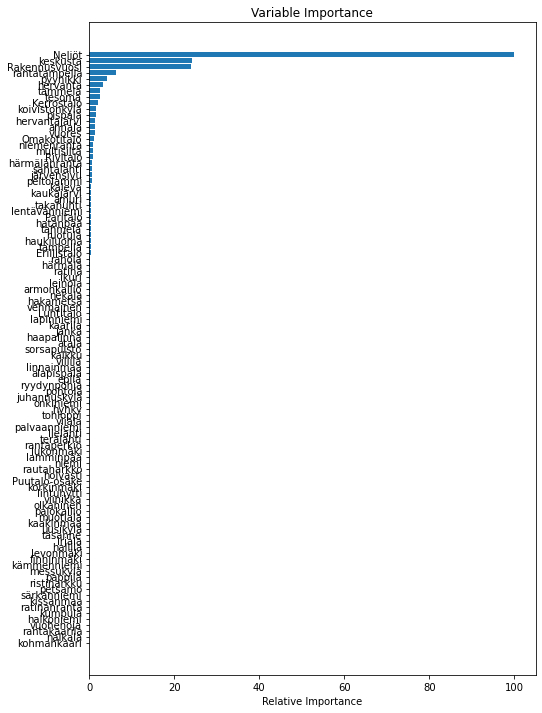

In [29]:
feature_importance = Tuned_Model2.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

In [30]:
y_pred = Tuned_Model2.predict(X_test)

Lasketaan mallin tarkkuusarvo.

In [31]:
errors = abs(y_pred-y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 89.06 %.


### Toimeenpano

Analyysin tuloksena syntyi analytiikkatyökalu, jonka avulla käyttäjä voi ennustaa Tampereella sijaitsevan asuntonsa myyntihinnan. Sovelluksen koodi on erillisessä main.py -tiedostossa.

Sovelluksen voi avata selaimessa alla olevasta linkistä:

https://share.streamlit.io/sofiaknn/house-price-predictor/main/main.py

Analyysiä olisi mahdollista parantaa monellakin tapaa:
 
- Datasta olisi voinut erotella enemmän piirteitä, kuten huoneluku, sauna, parveke, kerros jne. 
- Jos käytössä olisi enemmän dataa, esimerkiksi tasaisemmin eri asuinalueilta ja asuntotyypeistä, niin mallista saisi huomattavasti paremman.
- Etuovi.com -sivustolta kerätyt asuntojen hinnat eivät ole toteutuneita myyntihintoja ja lopullinen myyntihinta voi monesti olla joko pienempi tai suurempi kuin alkuperäinen pyyntihinta. Ennustettu hinta olisi siis todenmukaisempi, jos hinnat olisivat toteutuneita myyntihintoja.
